In [682]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

from scipy import spatial

color_list =["#3eb991","#e9a820","#e01563","#edb196","#6ecadc","#1f94ac","#ae9a6a","#ccb8a6","#343a44"]

In [683]:
# defining function for diffusion in 3D over time
def single_step(X, Y, theta, delta_T):
    
    # defining variables
    v = 1 * pow(10, -6); 
    omega = 0; 
    D_r = 0.05; 
    D_t = 0.1 * pow(10, -12); 

    delta_X, delta_Y = 0, 0; 
    delta_theta = 0; 

    # randomly sampling in a uniform distribution from 0 to 1 to get an angle
    W_theta = (math.pi / 2) * np.random.uniform(-1, 1); 

    # randomly sampling noise in Gaussian distrib. with mean 0 and variance 1
    W_X = np.random.normal(0, 1); 
    W_Y = np.random.normal(0, 1); 

    # solving change in position for each dimension
    delta_X = v * np.cos(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_X; 
    delta_Y = v * np.sin(theta) * delta_T + np.sqrt(2 * D_t * delta_T) * W_Y; 

    # solving change in each angle
    delta_theta = omega * delta_T + np.sqrt(2 * D_r * delta_T) * W_theta; 

    # using a temporary variable to track position and angle
    X += delta_X; 
    Y += delta_Y; 
    theta += delta_theta; 
    
    temp_postition = []; 
    temp_postition = np.array([X, Y, theta]); 

    return temp_postition; # returning coordinates and diffusion coefficient (for comparison later)

In [684]:
class makeSwimmer: # defines swimmer class
  def __init__(self, x, y, theta, start_time, parent): # one can enter with 0, 0, 0 start or other
    self.start_time = start_time; 
    self.position = np.array([[x, y, theta]]); 
    self.parent = parent; # the index of the swimmer you diverged from (in the list)
    self.closest_swimmer = 100000; # distance to closest swimmer

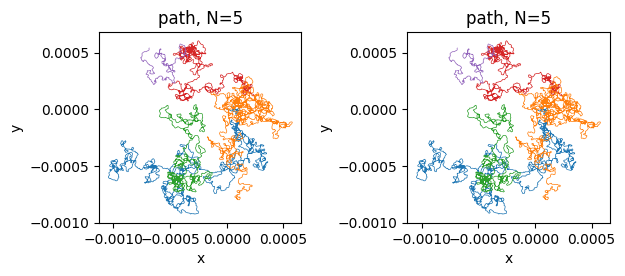

In [685]:
total_time = 20000; 
delta_T = 1; 
indexed_time = int(total_time / delta_T); # used to index through time list 
swimmer_Radius = 1 * pow(10, -7); # this is the swimmer size (too small?), so that when they divide their centers will be offset by this 

swimmerList = []; # a list of swimmers
for i in range(0, 1, 1): # initializes a list of 10 swimmers 
    swimmerList.append(makeSwimmer(0, 0, 0, 0, 0)); # set starting point at 0, 0

temp_coords_list = np.array([[0, 0]]); 
for time in range(0, indexed_time, 1): 

    temp_coords_list = np.delete(temp_coords_list, 0, 0); # removes first element of array, I think
    # print(temp_coords_list); 
    for i in range(0, len(swimmerList), 1):
        time_effective = time - swimmerList[i].start_time; # to make using the start time easier
        compare_coord = [[swimmerList[i].position[time_effective, 0], swimmerList[i].position[time_effective, 1]]]; 
        distances = spatial.distance.cdist(temp_coords_list, compare_coord).flatten(); # flatten added to reduce to 1D array
        distances = distances[distances != 0]; # used to remove / extract non-zero numbers (i.e., self)
        if(distances.size > 0): # added for when only 1 swimmer exists
            minimum = np.min(distances); # stores smallest distance
        else:
            minimum = 10000; 
        swimmerList[i].closest_swimmer = minimum; 
        # if (i == 0): print(str(distances) + "," + str(swimmerList[i].closest_swimmer)); 
    
    temp_coords_list = np.array([[0, 0]]); 
    
    for i in range(0, len(swimmerList), 1):
        time_effective = time - swimmerList[i].start_time; # to make using the start time easier
        arr = swimmerList[i].position[time_effective]; # to store the previous position

        temp_coords = single_step(arr[0], arr[1], arr[2], delta_T); 
        swimmerList[i].position = np.vstack((swimmerList[i].position, temp_coords));  
        temp_coords_list = np.vstack((temp_coords_list, [temp_coords[0], temp_coords[1]])); 

        # something like: p(divide) = exp(-k dt), where k = 1/distance
        if swimmerList[i].closest_swimmer > 0.001: # currently causing stoachstic cell division
            x_after_divide = arr[0] + swimmer_Radius; 
            y_after_divide = arr[1] + swimmer_Radius; 
            swimmerList.append(makeSwimmer(x_after_divide, y_after_divide, 0, time + 1, i)); # set starting point at 0, 0
            temp_coords_list = np.vstack((temp_coords_list, [x_after_divide, y_after_divide])); 

# 2d graphing definitions
plt.subplot(1, 2, 1); # putting plots on the same image, this at row 1, col 1, index 1
for i in range(0, len(swimmerList), 1):
    plt.plot(swimmerList[i].position[:,0], swimmerList[i].position[:,1], linewidth=0.5); 
    # here, : takes all values at position 0 (x) or 1 (y) for each swimmer in the list
    # plot then graphs all of those x and y independently 

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, N=" + str(len(swimmerList)))
plt.tight_layout()
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2); # putting plots on the same image, this at row 1, col 1, index 1
for i in range(0, len(swimmerList), 1):
    plt.plot(swimmerList[i].position[:,0], swimmerList[i].position[:,1], linewidth=0.5, color = color_list[swimmerList[i].parent]); 
    # here, : takes all values at position 0 (x) or 1 (y) for each swimmer in the list
    # plot then graphs all of those x and y independently 

plt.xlabel('x')
plt.ylabel('y')
plt.title("path, N=" + str(len(swimmerList)))
plt.tight_layout()
plt.gca().set_aspect('equal')